### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

### Loading the data and plotting visualizations

In [2]:
df = pd.read_csv("../data/heart.csv")

# Splitting the data into input and target
X = df.drop('target', axis=1)
Y = df['target']

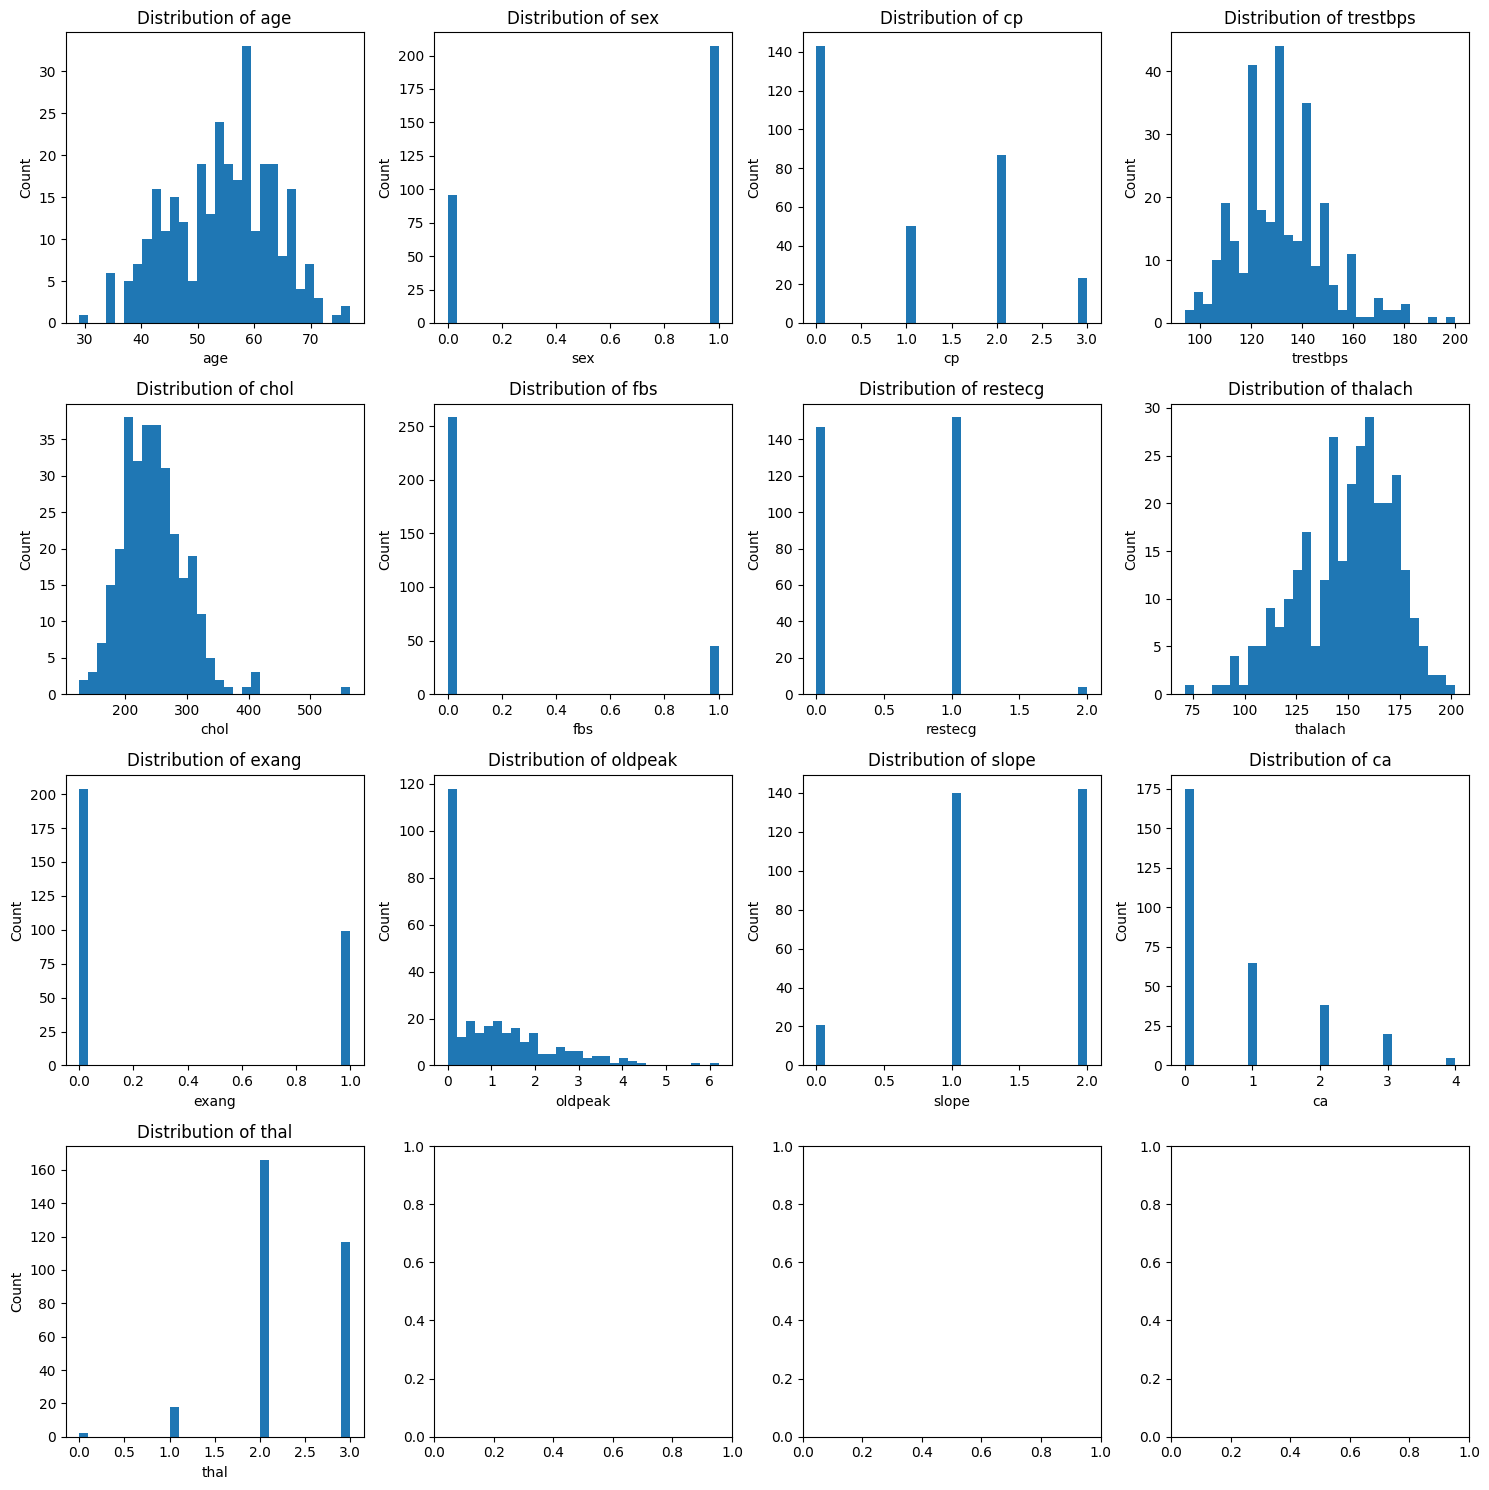

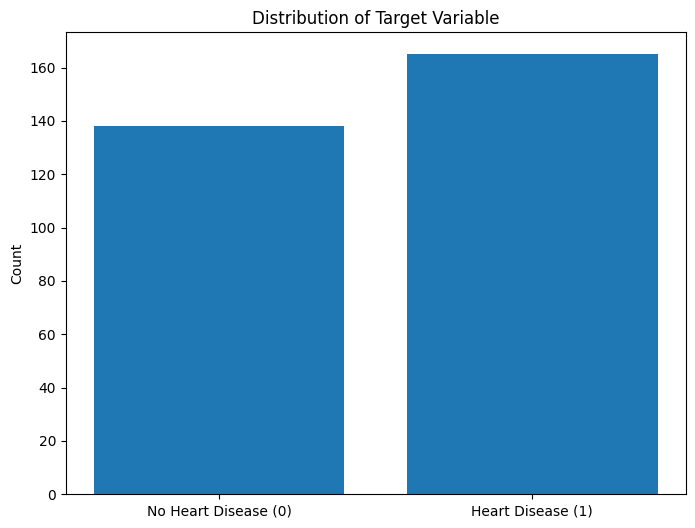

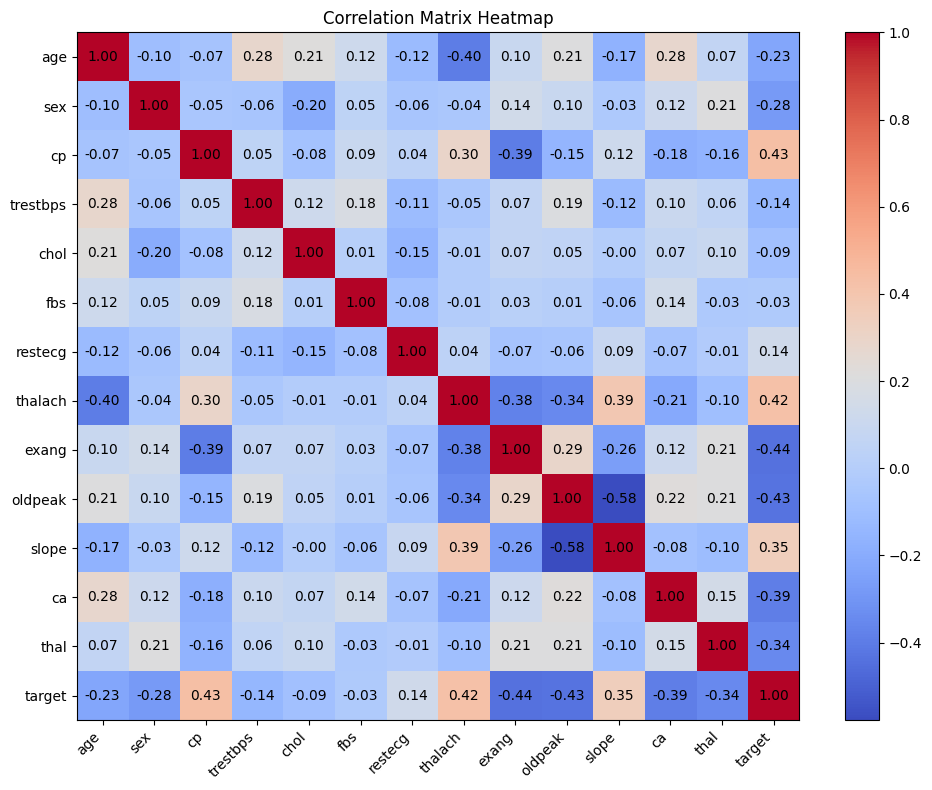

In [3]:
# Plotting the distribution of each feature
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[col], bins=30)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
plt.bar(['No Heart Disease (0)', 'Heart Disease (1)'], Y.value_counts().sort_index())
plt.title('Distribution of Target Variable')
plt.ylabel('Count')
plt.show()

# Plotting the correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

### Building the Neural Network


In [4]:
class NeuralNetwork:
    '''
    A class for building and training a neural network.

    Attributes:
        layer_dims (list): A list of integers representing the number of neurons in each layer.
        activations (list): A list of strings representing the activation function for each layer.
        learning_rate (float): The learning rate for the optimizer.
        decay (float): The decay rate for the learning rate.
        epochs (int): The number of epochs to train the model.
        batch_size (int): The batch size for training.
        dropout_rate (float): The dropout rate for the model.
        regularization (str): The regularization method for the model.
        reg_lambda (float): The regularization parameter for the model.
        grad_clip (float): The gradient clipping parameter for the model.
        seed (int): The random seed for reproducibility.
    '''	
    def __init__(
        self,
        layer_dims,
        activations,
        learning_rate=0.001,
        decay=0.001,
        epochs=1000,
        batch_size=32,
        dropout_rate=0.1,
        regularization=None,
        reg_lambda=0.01,
        grad_clip=1.0,
        seed=42
    ):
        self.layer_dims = layer_dims
        self.activations = activations
        self.learning_rate = learning_rate
        self.decay = decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.grad_clip = grad_clip
        self.set_seed(seed)
        self.params = self._initialize_parameters()
        
    def set_seed(self, seed):
        '''
        Sets random seed for reproducibility.

        Args:
            seed (int): Random seed value
        '''
        np.random.seed(seed)

    def _initialize_parameters(self):
        '''
        Initializes the parameters (weights and biases) of the neural network.
        Uses He initialization for weights and zeros for biases.

        Returns:
            parameters (dict): The initialized parameters of the neural network.
        '''
        parameters = {}
        
        for l in range(1, len(self.layer_dims)):
            parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2/self.layer_dims[l-1])
            parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
            
        return parameters

    def _activation_forward(self, Z, activation):
        '''
        Applies the activation function to the input.

        Args:
            Z (np.array): The input to the activation function.
            activation (str): The activation function to apply.

        Returns:
            A (np.array): The output of the activation function.
        '''	
        if activation == "relu":
            return np.maximum(0, Z)
        elif activation == "leaky_relu":
            return np.where(Z > 0, Z, 0.01 * Z)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        elif activation == "tanh":
            return np.tanh(Z)
        elif activation == "elu":
            return np.where(Z > 0, Z, 0.1 * (np.exp(Z) - 1))

    def _activation_backward(self, dA, Z, activation):
        '''
        Computes the backward pass of the activation function.

        Args:
            dA (np.array): The derivative of the activation function.
            Z (np.array): The input to the activation function.
            activation (str): The activation function to apply.

        Returns:
            dZ (np.array): The derivative of the activation function.
        '''		
        if activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ
        elif activation == "leaky_relu":
            dZ = np.where(Z > 0, dA, dA * 0.01)
            return dZ
        elif activation == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            return dA * s * (1 - s)
        elif activation == "tanh":
            t = np.tanh(Z)
            return dA * (1 - t ** 2)
        elif activation == "elu":
            dZ = np.where(Z > 0, dA, dA * (Z + 0.1))
            return dZ

    def _batch_norm(self, A, layer_index):
        '''
        Applies batch normalization to the input.

        Args:
            A (np.array): The input to the batch normalization.
            layer_index (int): The index of the layer to apply batch normalization to.

        Returns:
            A_out (np.array): The output of the batch normalization.
        '''
        mean = np.mean(A, axis=1, keepdims=True)
        variance = np.var(A, axis=1, keepdims=True)
        A_norm = (A - mean) / np.sqrt(variance + 1e-8)
        
        if f'gamma{layer_index}' not in self.params:
            self.params[f'gamma{layer_index}'] = np.ones((A.shape[0], 1))
            self.params[f'beta{layer_index}'] = np.zeros((A.shape[0], 1))
        
        A_out = self.params[f'gamma{layer_index}'] * A_norm + self.params[f'beta{layer_index}']
        return A_out 

    def _forward(self, X):
        '''
        Performs the forward pass of the neural network.

        Args:
            X (np.array): The input to the neural network.

        Returns:
            A_last (np.array): The output of the neural network.
        '''
        cache = {'A0': X}

        for i in range(1, len(self.layer_dims)):
            W = self.params[f'W{i}']
            b = self.params[f'b{i}']
            A_prev = cache[f'A{i-1}']
            Z = np.dot(W, A_prev) + b

            A = self._activation_forward(Z, self.activations[i-1])
            if i < len(self.layer_dims) - 1:
                A = self._batch_norm(A, i)
            
            if i < len(self.layer_dims) - 1 and self.dropout_rate > 0:
                dropout_mask = np.random.rand(*A.shape) > self.dropout_rate
                A *= dropout_mask / (1 - self.dropout_rate)
                cache[f'D{i}'] = dropout_mask

            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A

        return cache[f'A{len(self.layer_dims) - 1}'], cache


    def _backward(self, A_last, Y, cache):
        '''
        Performs the backward pass of the neural network.

        Args:
            A_last (np.array): The output of the neural network.
            Y (np.array): The target values.
            cache (dict): The cache of the forward pass.

        Returns:
            grads (dict): The gradients of the neural network.
        '''
        m = A_last.shape[1]
        grads = {}
        dA_prev = A_last - Y

        for i in range(len(self.layer_dims) - 1, 0, -1):
            A_prev = cache[f'A{i-1}']
            Z = cache[f'Z{i}']
            W = self.params[f'W{i}']

            dZ = self._activation_backward(dA_prev, Z, self.activations[i-1])
            grads[f'dW{i}'] = (1 / m) * np.dot(dZ, A_prev.T)
            grads[f'db{i}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(W.T, dZ)

            if self.regularization == "L2":
                grads[f'dW{i}'] += (self.reg_lambda / m) * W

            # Gradient clipping
            grads[f'dW{i}'] = np.clip(grads[f'dW{i}'], -self.grad_clip, self.grad_clip)
            grads[f'db{i}'] = np.clip(grads[f'db{i}'], -self.grad_clip, self.grad_clip)

        return grads

    def _update_params(self, grads):
        '''
        Updates the parameters of the neural network.

        Args:
            grads (dict): The gradients of the neural network.
        '''
        for i in range(1, len(self.layer_dims)):
            self.params[f'W{i}'] -= self.learning_rate * grads[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * grads[f'db{i}']

    def compute_loss(self, Y, A_last, class_weights={0: 1.0, 1: 1.8}):
        '''
        Computes the loss of the neural network.

        Args:
            Y (np.array): The target values.
            A_last (np.array): The output of the neural network.
            class_weights (dict): The class weights for the loss function.

        Returns:
            loss (float): The loss of the neural network.
        '''
        m = Y.shape[1]
        loss = -(class_weights[1] * Y * np.log(A_last + 1e-8) + class_weights[0] * (1 - Y) * np.log(1 - A_last + 1e-8))
        return np.sum(loss) / m

    def train(self, X, Y, X_val=None, Y_val=None, print_every=100):
        '''
        Trains the neural network.

        Args:
            X (np.array): The input to the neural network.
            Y (np.array): The target values.
            X_val (np.array): The validation input.
            Y_val (np.array): The validation target values.
            print_every (int): The number of epochs to print the loss.
        '''
        initial_learning_rate = self.learning_rate
        losses = []
        val_losses = []

        class_weights = compute_class_weight('balanced', classes=np.unique(Y.flatten()), y=Y.flatten())
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

        for epoch in range(self.epochs):
            self.learning_rate = initial_learning_rate * np.exp(-self.decay * epoch)
            A_last, cache = self._forward(X)
            loss = self.compute_loss(Y, A_last, class_weight_dict)
            losses.append(loss)

            if X_val is not None and Y_val is not None:
                A_val, _ = self._forward(X_val)
                val_loss = self.compute_loss(Y_val, A_val, class_weight_dict)
                val_losses.append(val_loss)

            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
                if X_val is not None and Y_val is not None:
                    print(f"Validation Loss: {val_loss:.4f}")

            grads = self._backward(A_last, Y, cache)
            self._update_params(grads)
        
        self.plot_loss(losses, X_val, Y_val, val_losses)

    def plot_loss(self, losses, X_val=None, Y_val=None, val_losses=None):
        '''
        Plots the loss curve of the neural network.

        Args:
            losses (list): The losses of the neural network.
        '''
        plt.plot(losses, label="Training Loss")
        if X_val is not None and Y_val is not None:
            plt.plot(val_losses, label="Validation Loss")
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


    def predict(self, X):
        '''
        Predicts the target values of the neural network.

        Args:
            X (np.array): The input to the neural network.

        Returns:
            predictions (np.array): The predictions of the neural network.
        '''
        A_last, _ = self._forward(X)
        return (A_last > 0.5).astype(int)

### Training the Neural Network and evaluating the performance

Training with learning rate: 0.0001 and dropout rate: 0.01
Epoch 0, Training Loss: 0.8313
Validation Loss: 0.8194
Epoch 500, Training Loss: 0.7684
Validation Loss: 0.8144
Epoch 1000, Training Loss: 0.7240
Validation Loss: 0.7383
Epoch 1500, Training Loss: 0.6888
Validation Loss: 0.7262
Epoch 2000, Training Loss: 0.6750
Validation Loss: 0.6815
Epoch 2500, Training Loss: 0.6407
Validation Loss: 0.6634


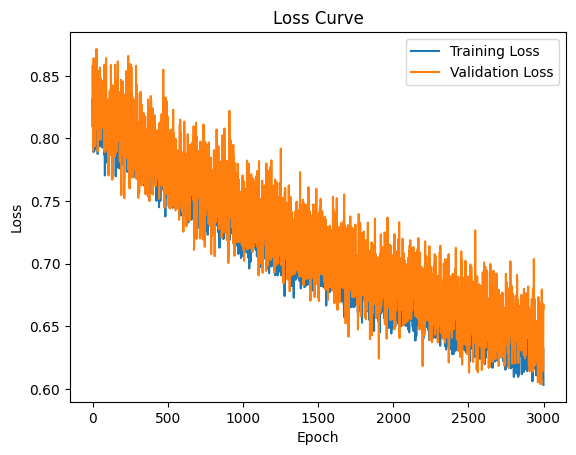

Testing Accuracy: 0.6721
Training with learning rate: 0.0001 and dropout rate: 0.05
Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.8027
Validation Loss: 0.8780
Epoch 1000, Training Loss: 0.7293
Validation Loss: 0.7508
Epoch 1500, Training Loss: 0.7043
Validation Loss: 0.7439
Epoch 2000, Training Loss: 0.7168
Validation Loss: 0.6936
Epoch 2500, Training Loss: 0.6427
Validation Loss: 0.6992


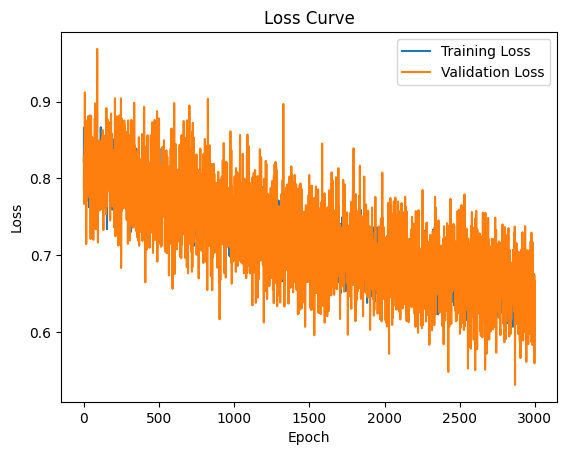

Testing Accuracy: 0.6066
Training with learning rate: 0.0001 and dropout rate: 0.1
Epoch 0, Training Loss: 0.8107
Validation Loss: 0.8507
Epoch 500, Training Loss: 0.8405
Validation Loss: 0.8483
Epoch 1000, Training Loss: 0.8038
Validation Loss: 0.7536
Epoch 1500, Training Loss: 0.7444
Validation Loss: 0.7294
Epoch 2000, Training Loss: 0.7249
Validation Loss: 0.6514
Epoch 2500, Training Loss: 0.6573
Validation Loss: 0.7457


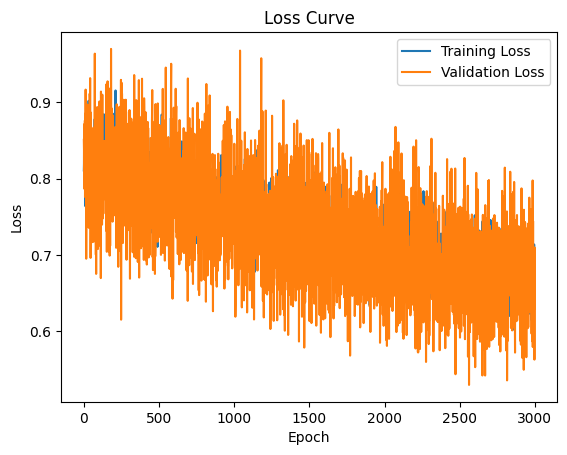

Testing Accuracy: 0.6557
Training with learning rate: 0.0001 and dropout rate: 0.2
Epoch 0, Training Loss: 0.8360
Validation Loss: 0.7971
Epoch 500, Training Loss: 0.8389
Validation Loss: 0.8131
Epoch 1000, Training Loss: 0.8007
Validation Loss: 0.8870
Epoch 1500, Training Loss: 0.8397
Validation Loss: 0.8276
Epoch 2000, Training Loss: 0.7557
Validation Loss: 0.7250
Epoch 2500, Training Loss: 0.7073
Validation Loss: 0.7756


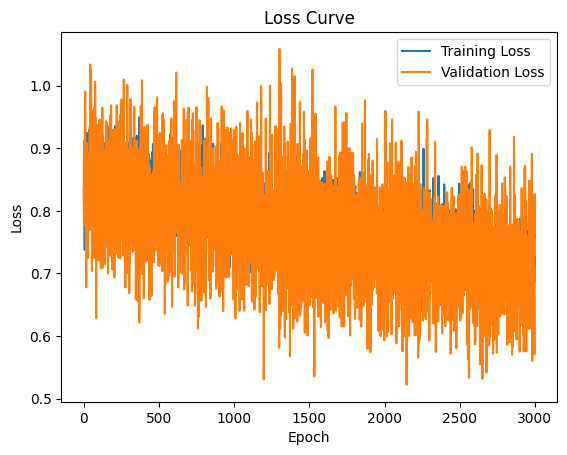

Testing Accuracy: 0.5902
Training with learning rate: 0.0001 and dropout rate: 0.5
Epoch 0, Training Loss: 1.0416
Validation Loss: 0.9192
Epoch 500, Training Loss: 0.9812
Validation Loss: 0.9205
Epoch 1000, Training Loss: 0.8856
Validation Loss: 0.8808
Epoch 1500, Training Loss: 0.9117
Validation Loss: 1.1590
Epoch 2000, Training Loss: 1.0045
Validation Loss: 0.9213
Epoch 2500, Training Loss: 0.8325
Validation Loss: 0.7828


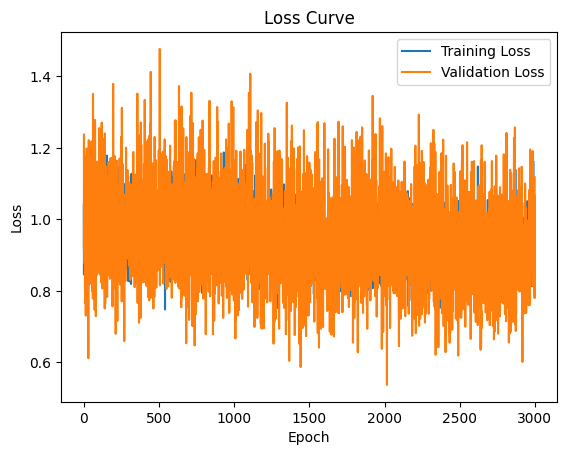

Testing Accuracy: 0.5410
Training with learning rate: 0.0005 and dropout rate: 0.01
Epoch 0, Training Loss: 0.8313
Validation Loss: 0.8194
Epoch 500, Training Loss: 0.6332
Validation Loss: 0.6847
Epoch 1000, Training Loss: 0.5450
Validation Loss: 0.5695
Epoch 1500, Training Loss: 0.4882
Validation Loss: 0.5457
Epoch 2000, Training Loss: 0.4653
Validation Loss: 0.5169
Epoch 2500, Training Loss: 0.4326
Validation Loss: 0.4867


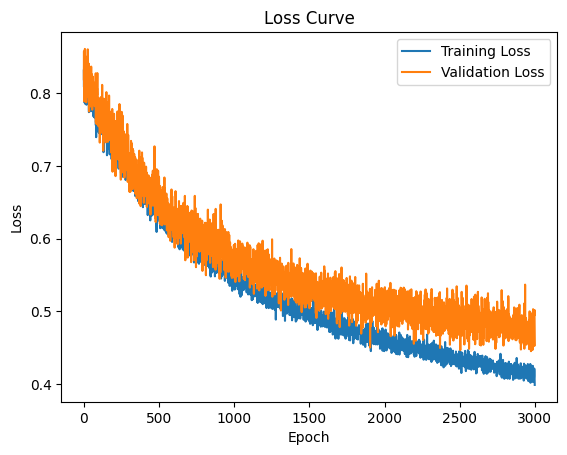

Testing Accuracy: 0.7869
Training with learning rate: 0.0005 and dropout rate: 0.05
Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.6739
Validation Loss: 0.7468
Epoch 1000, Training Loss: 0.5648
Validation Loss: 0.5751
Epoch 1500, Training Loss: 0.5179
Validation Loss: 0.5694
Epoch 2000, Training Loss: 0.5066
Validation Loss: 0.5348
Epoch 2500, Training Loss: 0.4449
Validation Loss: 0.5114


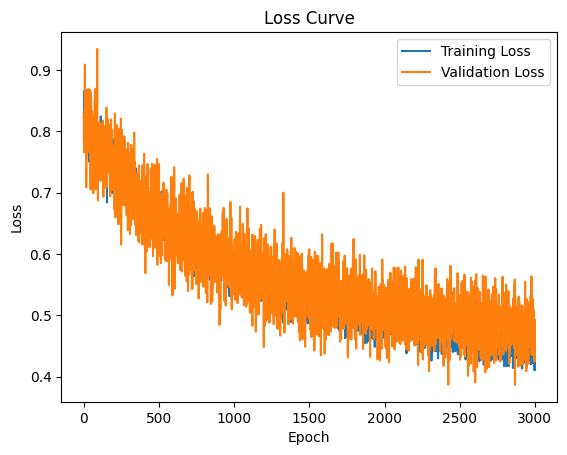

Testing Accuracy: 0.7541
Training with learning rate: 0.0005 and dropout rate: 0.1
Epoch 0, Training Loss: 0.8107
Validation Loss: 0.8507
Epoch 500, Training Loss: 0.7163
Validation Loss: 0.7353
Epoch 1000, Training Loss: 0.6371
Validation Loss: 0.5905
Epoch 1500, Training Loss: 0.5536
Validation Loss: 0.5503
Epoch 2000, Training Loss: 0.5290
Validation Loss: 0.5007
Epoch 2500, Training Loss: 0.4637
Validation Loss: 0.5542


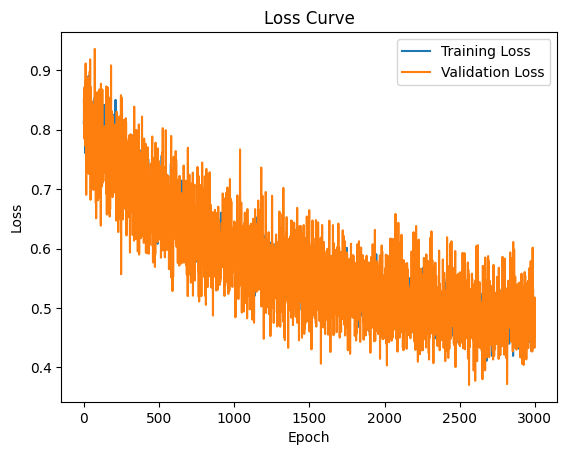

Testing Accuracy: 0.7869
Training with learning rate: 0.0005 and dropout rate: 0.2
Epoch 0, Training Loss: 0.8360
Validation Loss: 0.7971
Epoch 500, Training Loss: 0.7421
Validation Loss: 0.7187
Epoch 1000, Training Loss: 0.6518
Validation Loss: 0.7048
Epoch 1500, Training Loss: 0.6497
Validation Loss: 0.6397
Epoch 2000, Training Loss: 0.5603
Validation Loss: 0.5430
Epoch 2500, Training Loss: 0.4930
Validation Loss: 0.5808


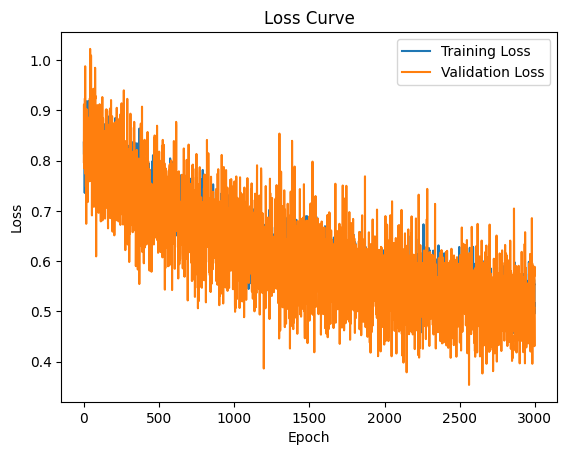

Testing Accuracy: 0.7705
Training with learning rate: 0.0005 and dropout rate: 0.5
Epoch 0, Training Loss: 1.0416
Validation Loss: 0.9192
Epoch 500, Training Loss: 0.9195
Validation Loss: 0.8634
Epoch 1000, Training Loss: 0.7872
Validation Loss: 0.7499
Epoch 1500, Training Loss: 0.7753
Validation Loss: 0.9931
Epoch 2000, Training Loss: 0.8272
Validation Loss: 0.7098
Epoch 2500, Training Loss: 0.6438
Validation Loss: 0.6285


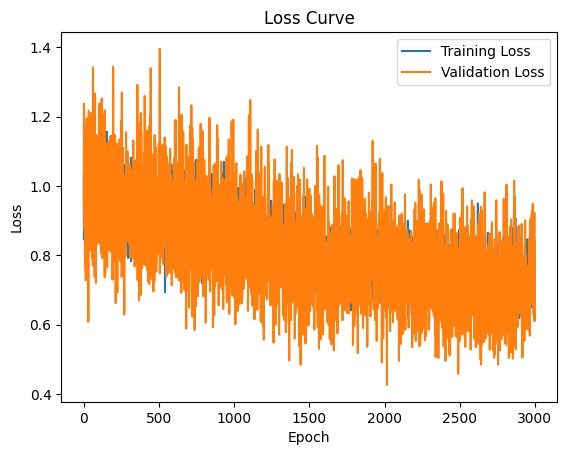

Testing Accuracy: 0.6557
Training with learning rate: 0.001 and dropout rate: 0.01
Epoch 0, Training Loss: 0.8313
Validation Loss: 0.8194
Epoch 500, Training Loss: 0.5410
Validation Loss: 0.6011
Epoch 1000, Training Loss: 0.4525
Validation Loss: 0.5026
Epoch 1500, Training Loss: 0.3990
Validation Loss: 0.4858
Epoch 2000, Training Loss: 0.3775
Validation Loss: 0.4729
Epoch 2500, Training Loss: 0.3475
Validation Loss: 0.4437


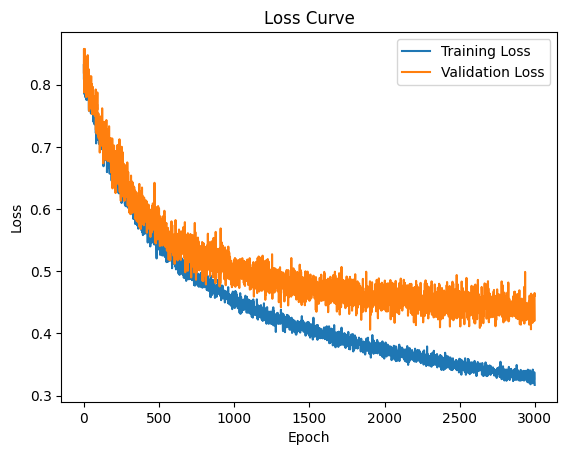

Testing Accuracy: 0.8361
Training with learning rate: 0.001 and dropout rate: 0.05
Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.5842
Validation Loss: 0.6577
Epoch 1000, Training Loss: 0.4779
Validation Loss: 0.4994
Epoch 1500, Training Loss: 0.4327
Validation Loss: 0.5082
Epoch 2000, Training Loss: 0.4183
Validation Loss: 0.4852
Epoch 2500, Training Loss: 0.3635
Validation Loss: 0.4669


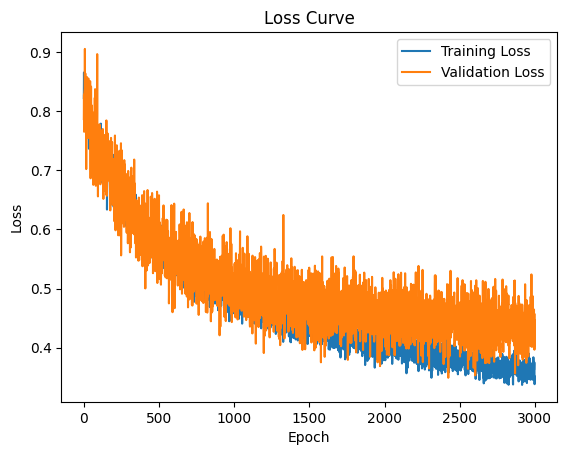

Testing Accuracy: 0.8033
Training with learning rate: 0.001 and dropout rate: 0.1
Epoch 0, Training Loss: 0.8107
Validation Loss: 0.8507
Epoch 500, Training Loss: 0.6263
Validation Loss: 0.6531
Epoch 1000, Training Loss: 0.5430
Validation Loss: 0.5095
Epoch 1500, Training Loss: 0.4638
Validation Loss: 0.4836
Epoch 2000, Training Loss: 0.4443
Validation Loss: 0.4520
Epoch 2500, Training Loss: 0.3856
Validation Loss: 0.5030


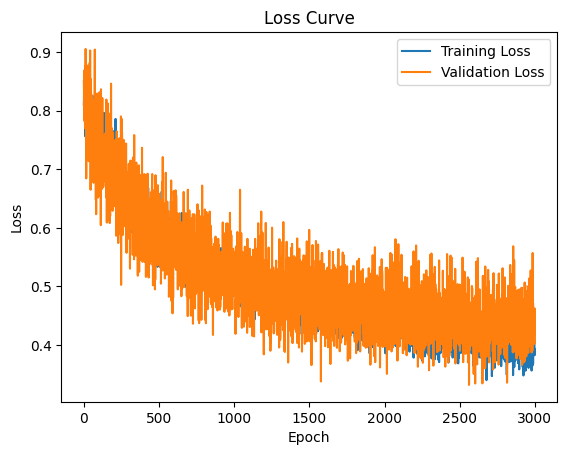

Testing Accuracy: 0.8033
Training with learning rate: 0.001 and dropout rate: 0.2
Epoch 0, Training Loss: 0.8360
Validation Loss: 0.7971
Epoch 500, Training Loss: 0.6651
Validation Loss: 0.6451
Epoch 1000, Training Loss: 0.5629
Validation Loss: 0.6012
Epoch 1500, Training Loss: 0.5513
Validation Loss: 0.5574
Epoch 2000, Training Loss: 0.4721
Validation Loss: 0.4754
Epoch 2500, Training Loss: 0.4096
Validation Loss: 0.5141


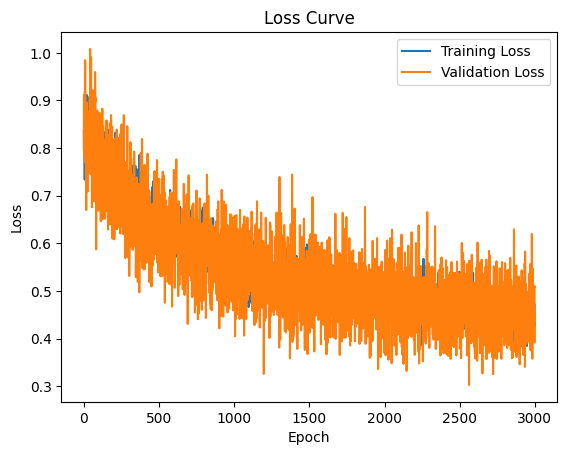

Testing Accuracy: 0.8033
Training with learning rate: 0.001 and dropout rate: 0.5
Epoch 0, Training Loss: 1.0416
Validation Loss: 0.9192
Epoch 500, Training Loss: 0.8552
Validation Loss: 0.8063
Epoch 1000, Training Loss: 0.7022
Validation Loss: 0.6408
Epoch 1500, Training Loss: 0.6796
Validation Loss: 0.8688
Epoch 2000, Training Loss: 0.7089
Validation Loss: 0.5671
Epoch 2500, Training Loss: 0.5378
Validation Loss: 0.5509


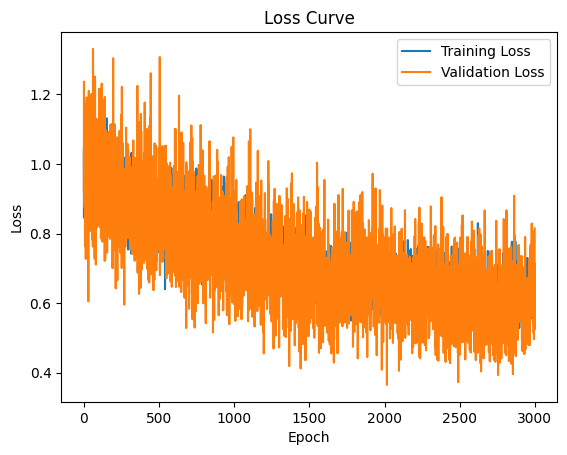

Testing Accuracy: 0.7049
Training with learning rate: 0.005 and dropout rate: 0.01
Epoch 0, Training Loss: 0.8313
Validation Loss: 0.8194
Epoch 500, Training Loss: 0.3327
Validation Loss: 0.4675
Epoch 1000, Training Loss: 0.2556
Validation Loss: 0.4414
Epoch 1500, Training Loss: 0.2073
Validation Loss: 0.4474
Epoch 2000, Training Loss: 0.1849
Validation Loss: 0.4595
Epoch 2500, Training Loss: 0.1643
Validation Loss: 0.4390


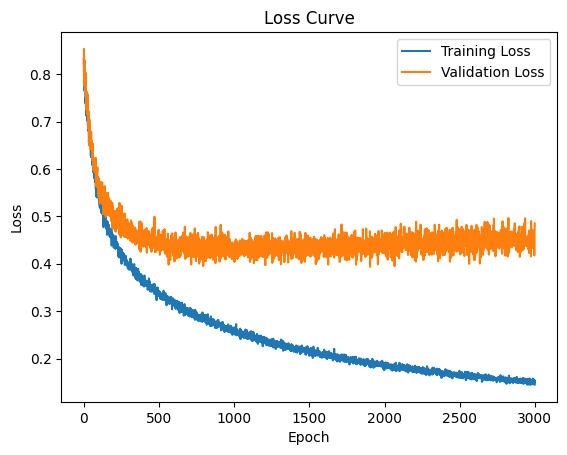

Testing Accuracy: 0.8525
Training with learning rate: 0.005 and dropout rate: 0.05
Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.3773
Validation Loss: 0.5029
Epoch 1000, Training Loss: 0.2911
Validation Loss: 0.4153
Epoch 1500, Training Loss: 0.2471
Validation Loss: 0.4578
Epoch 2000, Training Loss: 0.2327
Validation Loss: 0.4540
Epoch 2500, Training Loss: 0.1932
Validation Loss: 0.4581


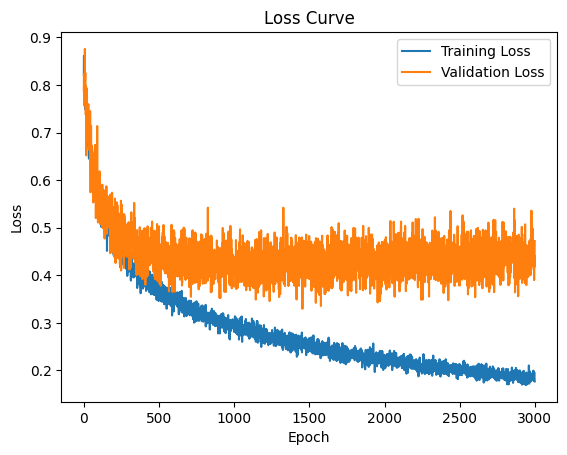

Testing Accuracy: 0.8525
Training with learning rate: 0.005 and dropout rate: 0.1
Epoch 0, Training Loss: 0.8107
Validation Loss: 0.8507
Epoch 500, Training Loss: 0.4189
Validation Loss: 0.4917
Epoch 1000, Training Loss: 0.3447
Validation Loss: 0.3889
Epoch 1500, Training Loss: 0.2821
Validation Loss: 0.4274
Epoch 2000, Training Loss: 0.2708
Validation Loss: 0.4218
Epoch 2500, Training Loss: 0.2217
Validation Loss: 0.4726


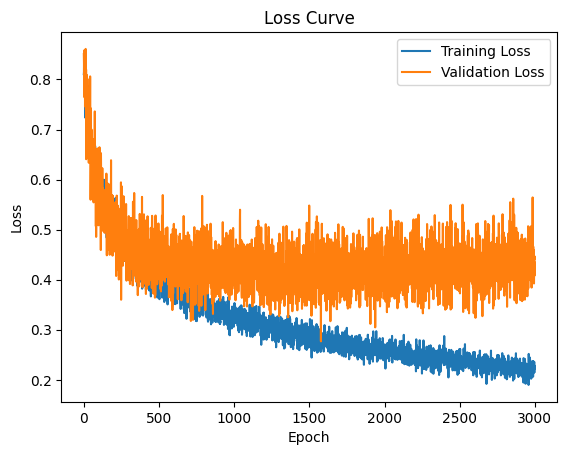

Testing Accuracy: 0.8689
Training with learning rate: 0.005 and dropout rate: 0.2
Epoch 0, Training Loss: 0.8360
Validation Loss: 0.7971
Epoch 500, Training Loss: 0.4800
Validation Loss: 0.5030
Epoch 1000, Training Loss: 0.3813
Validation Loss: 0.4404
Epoch 1500, Training Loss: 0.3607
Validation Loss: 0.4708
Epoch 2000, Training Loss: 0.3083
Validation Loss: 0.4101
Epoch 2500, Training Loss: 0.2595
Validation Loss: 0.4650


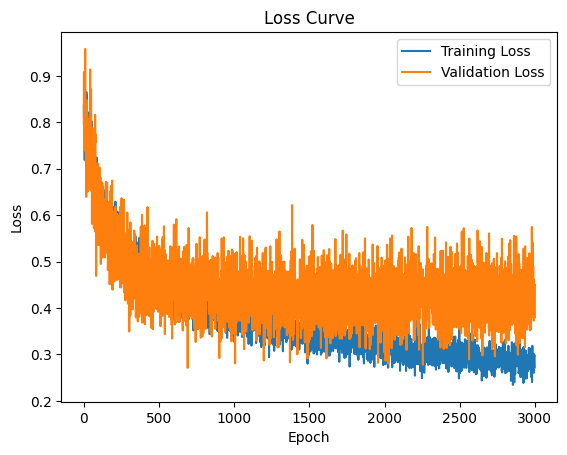

Testing Accuracy: 0.8689
Training with learning rate: 0.005 and dropout rate: 0.5
Epoch 0, Training Loss: 1.0416
Validation Loss: 0.9192
Epoch 500, Training Loss: 0.6129
Validation Loss: 0.6027
Epoch 1000, Training Loss: 0.4946
Validation Loss: 0.4077
Epoch 1500, Training Loss: 0.4966
Validation Loss: 0.6306
Epoch 2000, Training Loss: 0.4840
Validation Loss: 0.3501
Epoch 2500, Training Loss: 0.3737
Validation Loss: 0.4796


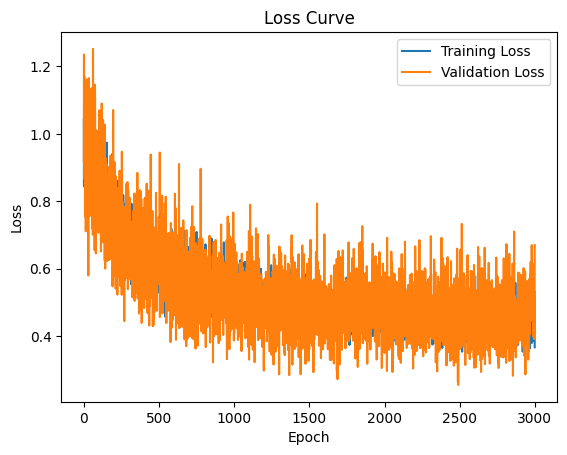

Testing Accuracy: 0.8197
Training with learning rate: 0.01 and dropout rate: 0.01
Epoch 0, Training Loss: 0.8313
Validation Loss: 0.8194
Epoch 500, Training Loss: 0.2492
Validation Loss: 0.4517
Epoch 1000, Training Loss: 0.1786
Validation Loss: 0.4542
Epoch 1500, Training Loss: 0.1349
Validation Loss: 0.4708
Epoch 2000, Training Loss: 0.1195
Validation Loss: 0.4932
Epoch 2500, Training Loss: 0.1042
Validation Loss: 0.4781


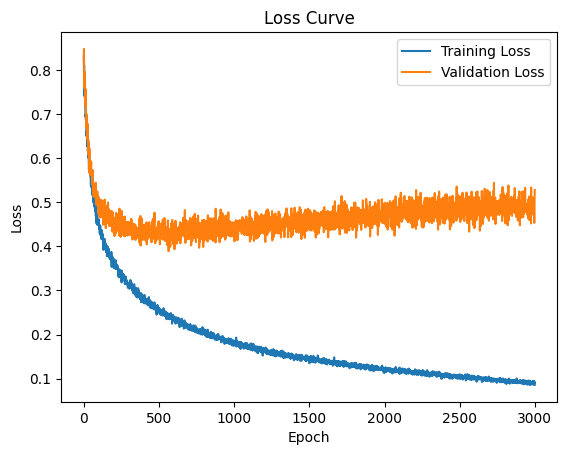

Testing Accuracy: 0.8525
Training with learning rate: 0.01 and dropout rate: 0.05
Epoch 0, Training Loss: 0.8220
Validation Loss: 0.7866
Epoch 500, Training Loss: 0.2941
Validation Loss: 0.4787
Epoch 1000, Training Loss: 0.2141
Validation Loss: 0.4224
Epoch 1500, Training Loss: 0.1681
Validation Loss: 0.4798
Epoch 2000, Training Loss: 0.1620
Validation Loss: 0.4817
Epoch 2500, Training Loss: 0.1310
Validation Loss: 0.4984


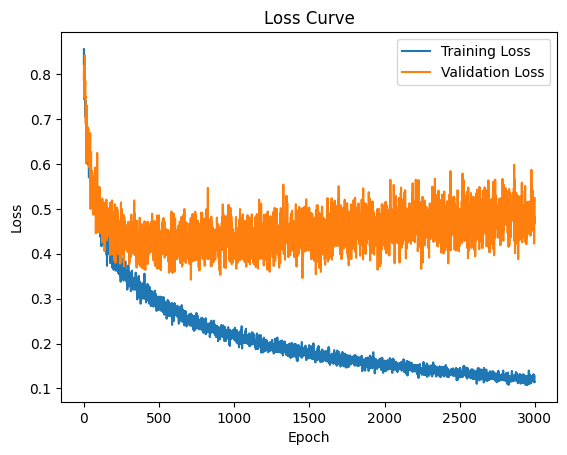

Testing Accuracy: 0.8525
Training with learning rate: 0.01 and dropout rate: 0.1
Epoch 0, Training Loss: 0.8107
Validation Loss: 0.8507
Epoch 500, Training Loss: 0.3370
Validation Loss: 0.4636
Epoch 1000, Training Loss: 0.2644
Validation Loss: 0.3701
Epoch 1500, Training Loss: 0.2049
Validation Loss: 0.4565
Epoch 2000, Training Loss: 0.2010
Validation Loss: 0.4452
Epoch 2500, Training Loss: 0.1595
Validation Loss: 0.5013


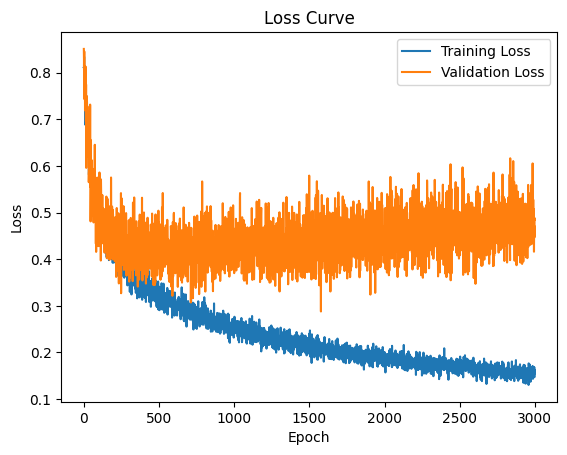

Testing Accuracy: 0.8525
Training with learning rate: 0.01 and dropout rate: 0.2
Epoch 0, Training Loss: 0.8360
Validation Loss: 0.7971
Epoch 500, Training Loss: 0.4133
Validation Loss: 0.4893
Epoch 1000, Training Loss: 0.3137
Validation Loss: 0.4161
Epoch 1500, Training Loss: 0.2845
Validation Loss: 0.4782
Epoch 2000, Training Loss: 0.2426
Validation Loss: 0.4215
Epoch 2500, Training Loss: 0.1969
Validation Loss: 0.4884


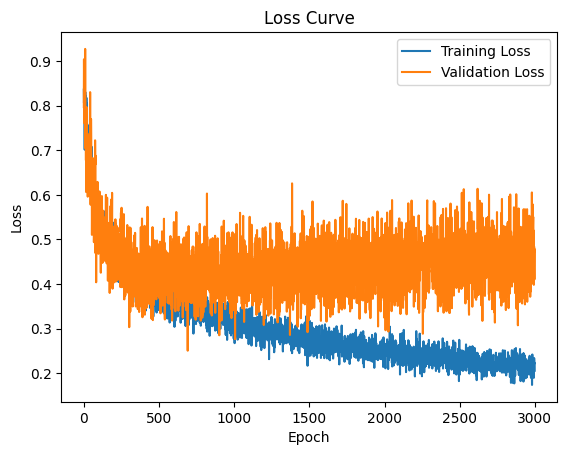

Testing Accuracy: 0.8525
Training with learning rate: 0.01 and dropout rate: 0.5
Epoch 0, Training Loss: 1.0416
Validation Loss: 0.9192
Epoch 500, Training Loss: 0.5237
Validation Loss: 0.5395
Epoch 1000, Training Loss: 0.4266
Validation Loss: 0.3718
Epoch 1500, Training Loss: 0.4368
Validation Loss: 0.5930
Epoch 2000, Training Loss: 0.4181
Validation Loss: 0.3326
Epoch 2500, Training Loss: 0.3241
Validation Loss: 0.4892


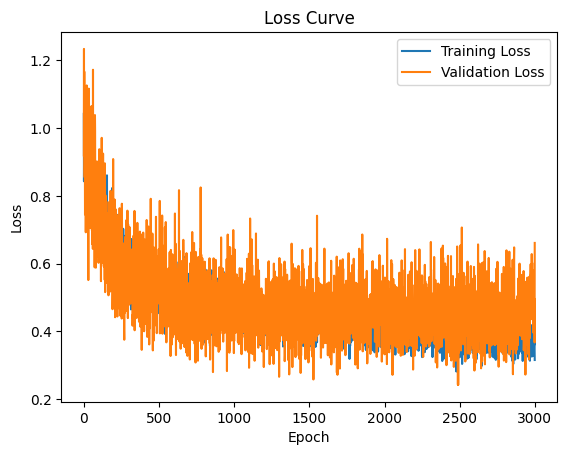

Testing Accuracy: 0.8689
Best learning rate: 0.005
Best dropout rate: 0.1
Best accuracy: 0.8689


In [11]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_binary = y_train.to_numpy().reshape(1, -1)
y_test_binary = y_test.to_numpy().reshape(1, -1)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
best_learning_rate = None
best_dropout_rate = None
best_accuracy = 0

for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training with learning rate: {learning_rate} and dropout rate: {dropout_rate}")
        # Building the Neural Network
        nn = NeuralNetwork(
            layer_dims=[X_train.shape[1], 512, 256, 128, 1],
            activations=['relu', 'relu', 'relu', 'sigmoid'],
            learning_rate=learning_rate,
            decay=0.0001,
            epochs=3000,
            dropout_rate=dropout_rate,
            regularization="L2",
            reg_lambda=0.005,
            batch_size=32,
            seed=1500
        )

        # Training the Neural Network
        nn.train(X_train.T, y_train_binary, X_val=X_test.T, Y_val=y_test_binary, print_every=500)

        # Making predictions and calculating accuracies
        test_predictions = nn.predict(X_test.T)
        test_accuracy = np.mean(test_predictions == y_test_binary.flatten())
        print(f"Testing Accuracy: {test_accuracy:.4f}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_learning_rate = learning_rate
            best_dropout_rate = dropout_rate

print(f"Best learning rate: {best_learning_rate}")
print(f"Best dropout rate: {best_dropout_rate}")
print(f"Best accuracy: {best_accuracy:.4f}")




In [12]:
np.random.seed(55551)

# Making predictions and calculating accuracies
train_predictions = nn.predict(X_train.T)
test_predictions = nn.predict(X_test.T)

train_accuracy = np.mean(train_predictions == y_train_binary.flatten())
best_accuracy = np.mean(test_predictions == y_test_binary.flatten())

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {best_accuracy:.4f}")


Training Accuracy: 0.8760
Testing Accuracy: 0.8689


### Training the KNN model and evaluating the performance

In [7]:
from collections import Counter

class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [8]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, random_state=42)

# Initialize the KNN model
knn = KNN(k=11)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = knn.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.41%
